# condtional DC-WGAN-GP with MNIST

In this Notebook, we try to build a conditional GAN using Convolutional Neural Networks.

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from viz import updatable_display2

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = 'MNIST'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
L = 28

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d): 
        if m.weight is not None:
            init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.0)
    elif isinstance(m, nn.Linear):
        if m.weight is not None:
            init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.0)

def noise(size,noise_dim):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = torch.randn(size, noise_dim)
    return n.to(device)

def images_to_vectors(images):
    """
    flatten batch of images
    """
    return images.view(images.size(0), L**2)

def vectors_to_images(vectors):
    """
    reconstruct batch of images from batch of flattened images
    """
    return vectors.view(vectors.size(0), 1, L, L)

def oneHot(y,data_dim):
    shp = y.size()
    y = y.view(-1,1)
    y_onehot = torch.LongTensor(y.size()[0], data_dim)
    y_onehot.zero_()
    y_onehot.scatter_(1, y, 1)
    return y_onehot.view(*shp[:-1],data_dim).contiguous()

In [ ]:
class Generator(nn.Module):
    def __init__(self, y_size, z_size, out_size=1, n_features_zero=128):
        super(Generator, self).__init__()
        self.z_size = z_size
        self.y_size = y_size
        self.out_size = out_size
        self.width_zero = 1
        self.n_features_zero = n_features_zero
        self.crop = 2
        self.y_cast = nn.Linear(y_size+z_size,y_size)
        self.main = nn.ModuleList([
            
                nn.ConvTranspose2d(y_size, n_features_zero * 4, 3, stride=2, padding=0,output_padding=1),
                nn.BatchNorm2d(n_features_zero * 4),
                nn.ReLU(inplace=True),
            
                nn.ConvTranspose2d(n_features_zero * 4, n_features_zero * 2, 3, stride=2, padding=1,output_padding=1),
                nn.BatchNorm2d(n_features_zero * 2),
                nn.ReLU(inplace=True),
            
                nn.ConvTranspose2d(n_features_zero * 2, n_features_zero,3, stride=2, padding=1,output_padding=1),
                nn.BatchNorm2d(n_features_zero),
                nn.ReLU(inplace=True),
            
                nn.ConvTranspose2d(n_features_zero, self.out_size, 3, stride=2, padding=1,output_padding=1),
                nn.Tanh()
        ])

    def forward(self, x,y):
        x = self.y_cast(torch.cat([x.squeeze(),y.squeeze()],1))
        x = x.view(-1,x.size()[1], self.width_zero,self.width_zero )
        for l in self.main:
            x = l(x)
        r = self.crop
        x = x[:,:,r:-r,r:-r]
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, y_size, in_size=1, n_features_zero=128):
        super(Discriminator, self).__init__()
        self.y_size = y_size
        self.in_size = in_size

        self.main = nn.ModuleList([
            
                nn.Sequential(
                    nn.Conv2d(in_size, n_features_zero, 3, stride=2, padding=1),
                    nn.LeakyReLU(0.2,inplace=True)),
            
                nn.Sequential(
                    nn.Conv2d(n_features_zero, n_features_zero*2, 3, stride=2, padding=1),
                    nn.LeakyReLU(0.2,inplace=True)),
            
                nn.Sequential(
                    nn.Conv2d(n_features_zero*2+y_size, n_features_zero*4, 3, stride=2, padding=1),
                    nn.LeakyReLU(0.2,inplace=True)),
            
                nn.Sequential(
                    nn.Conv2d(n_features_zero*4+y_size, n_features_zero*8, 3, stride=2, padding=1),
                    nn.LeakyReLU(0.2,inplace=True)),
            
                nn.Conv2d(n_features_zero*8+y_size, 1, 4, stride=1, padding=1)
                #nn.Conv2d(n_features_zero*4+y_size, 1, 4, stride=1, padding=1)
        ])

    def forward(self, x,y):
        #x,y = X[0],X[1]
        for k,l in enumerate(self.main):
            if k > 1:
                y_ = y.expand(-1,-1,x.size()[2],x.size()[3])
                x = torch.cat([x,y_],1)
                x = l(x)
            else:
                x = l(x)
        return x

##### WGAN-GP: gradients penalty

The key element to make this model work was to carrefuly design the gradient penalty: at first, I was computing the penalty only with regards to the input image $x$ without taking the labels input $y$ into account. Adding the penalty fixed this issue, ensuring $D$ to be k-Lipschitz and the model to converge.

In [6]:
LAMBDA = 10 # 10: recommended value from the original paper

def calc_gradient_penalty(netD, real_data, fake_data, real_labels,fake_labels):
    gradient_penalty = 0
    for x,y in [(real_data, real_labels), (fake_data,fake_labels)]: # removed interpolates and compute for each batch
        x = x.requires_grad_()
        y = y.requires_grad_()
        outputs = netD(x,y)
        gradients = autograd.grad(outputs=outputs, inputs=(x,y),
                                  grad_outputs=torch.ones(outputs.size()).to(device),
                                  create_graph=True, retain_graph=True, only_inputs=True)

        #gradients = gradients[0] + gradients[1] # conditional gan: gradients must be take 
        # c GAN takes two inputs: gradients relative to both inputs must be summed
        for k,g in enumerate(gradients):
            penalty = ((g.norm(2, dim=1) - 1) ** 2).mean() # encourage gradients to go towards 1
            gradient_penalty += penalty
            
    return gradient_penalty 


def calc_gradient_penalty_original(netD, real_data, fake_data, real_labels,fake_labels):
    alpha = torch.rand(real_data.size(0), 1).requires_grad_()
    alpha = alpha[:,:,None,None]
    alpha_img = alpha.expand(real_data.size())
    alpha_img = alpha_img.to(device) 
    alpha_label = alpha.expand(real_labels.size())
    alpha_label = alpha_label.to(device) 

    interpolates = alpha_img * real_data + ((1 - alpha_img) * fake_data)
    interpolates = interpolates.to(device)
    label_interpolates = alpha_label * real_labels + ((1 - alpha_label) * fake_labels)
    label_interpolates = label_interpolates.to(device)
    
    disc_interpolates = netD(interpolates,label_interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=(interpolates,label_interpolates),
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)
    
    #gradients = gradients[0] + gradients[1] # conditional gan: gradients must be take 
    # c GAN takes two inputs: gradients relative to both inputs must be summed
    gradient_penalty = (((gradients[0].norm(2, dim=1) - 1) ** 2).mean() + ((gradients[1].norm(2, dim=1) - 1) ** 2).mean() )* LAMBDA # encourage gradients to go towards 1
    return gradient_penalty

## Training

In [7]:
condition_dim = 10
batch_size = 128
m = 10
lr = 5e-4
noise_dim = 100
n_out = L**2
n_features_zero = 64

num_test_samples = m**2
test_noise = noise(num_test_samples,noise_dim)[:,:,None,None]

# models
try:
    del generator
except:
    0
try:
    del discriminator
except:
    0
generator = Generator(y_size=condition_dim, z_size=noise_dim,n_features_zero=n_features_zero).to(device)
discriminator = Discriminator(y_size=condition_dim,n_features_zero=n_features_zero).to(device)

# init
generator.apply(weights_init)
discriminator.apply(weights_init)

# otpimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)#, betas=(0,0.9))
g_optimizer = optim.Adam(generator.parameters(), lr=lr)#, betas=(0,0.9)) #RMSprop

# data loader
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

# Create logger instance
dis = updatable_display2(['train'],["epoch","d_error","g_error"])
# Total number of epochs to train
num_epochs = 200
global_step=0
epoch =0
g_error = 0

In [8]:
def train_discriminator(optimizer, real_data, real_labels, fake_data, fake_labels):
    optimizer.zero_grad()
    # 1.1 Train on Real Data
    real_input = real_data #torch.cat(real_data,real_labels],1)
    prediction_real = discriminator(real_input,real_labels).squeeze()
    # 1.2 Train on Fake Data
    fake_input = fake_data #torch.cat([fake_data,fake_labels],1)
    prediction_fake = discriminator(fake_input,fake_labels).squeeze()
    # gradients penalty (Lipschitz condition) (WGAN-GP)
    penalty = calc_gradient_penalty(discriminator,real_input, fake_input,real_labels,fake_labels)
    loss = prediction_fake.mean() - prediction_real.mean() + penalty
    loss.backward()
    optimizer.step()
    
    # 1.4 clip D parameters (Lipschitz condition) (orignal WGAN)
    #for p in discriminator.parameters():
    #    p.data.clamp_(-clipping_value, clipping_value)
    return loss

In [9]:
def train_generator(optimizer, fake_data, fake_labels):
    optimizer.zero_grad()
    prediction = discriminator(fake_data,fake_labels).squeeze() 
    G_loss = - torch.mean(prediction)
    G_loss.backward()#retain_graph=True)
    #print("fake_labels-grad:", fake_labels.grad)
    optimizer.step()
    return G_loss

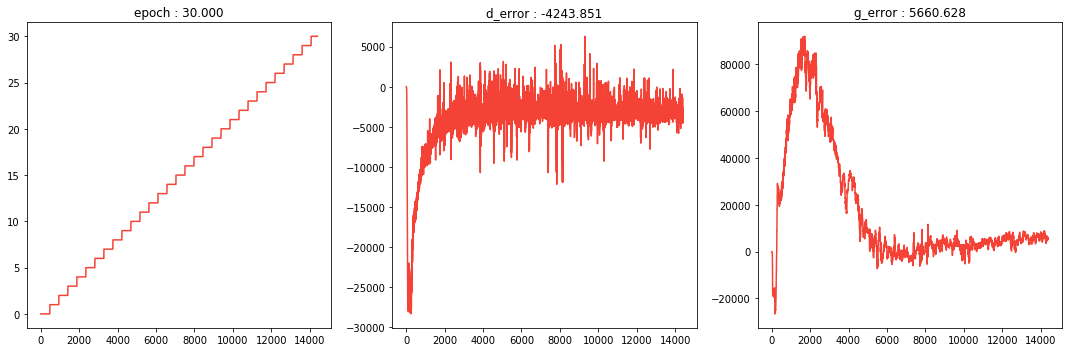

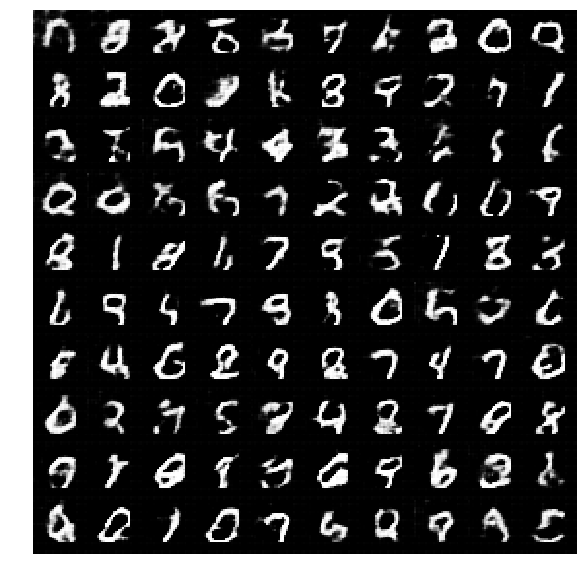

KeyboardInterrupt: 

In [10]:
gen_steps = 1
gen_train_freq = 5
if True:
    while True:
        for n_batch, (real_batch,label_batch) in enumerate(data_loader):
            #one hot labels
            label_batch = oneHot(label_batch[:,None],10).float().to(device)[:,:,None,None]

            N = real_batch.size(0)
            # 1. Train Discriminator
            real_data = real_batch.to(device) #images_to_vectors(real_batch).to(device)
            # Generate fake data and detach 
            # (so gradients are not calculated for generator)
            noise_tensor = noise(N,noise_dim)[:,:,None,None]
            random_labels = torch.randint(10, size=(N,1) ).long()
            random_labels = oneHot(random_labels,10).float().to(device)[:,:,None,None]
            with torch.no_grad():
                fake_data = generator(noise_tensor, random_labels)# torch.cat([noise_tensor,random_labels],1)).detach()
            # Train D
            d_error = train_discriminator(d_optimizer, real_data,label_batch, fake_data,random_labels)

            if global_step % gen_train_freq == 0:
                for _ in range(gen_steps):
                    # 2. Train Generator
                    # Generate fake data
                    noise_tensor = noise(N,noise_dim)[:,:,None,None]
                    random_labels = torch.randint(10, size=(N,1) ).long()
                    random_labels = oneHot(random_labels,10).float().to(device)[:,:,None,None]
                    
                    fake_data = generator(noise_tensor,random_labels) #torch.cat([noise_tensor,random_labels],1))
                    # Train G
                    g_error = train_generator(g_optimizer, fake_data,random_labels)
                    g_error = g_error.item()
            # Log batch error
            dis.update(global_step,'train',{"epoch":epoch,"d_error":d_error.item(),"g_error":g_error} )
            global_step+=1
            del fake_data
            del real_data
            del noise_tensor
            # Display Progress every few batches
            if global_step % 50 == 0:
                labels = torch.from_numpy(np.asarray([[k for k in range(m)] for _ in range(m)]).flatten())
                labels = oneHot(labels[:,None],10).float().to(device)[:,:,None,None]
                test_images = generator(test_noise, labels).squeeze() 
                test_images = test_images.data
                L = 28
                canvas = np.zeros((L*m,L*m))
                q = 0
                for i in range(m):
                    for j in range(m):
                        canvas[i*L:(i+1)*L,j*L:(j+1)*L] = test_images[q]
                        q+=1
                dis.display(scale=False)
                plt.figure(figsize=(10,10))
                plt.imshow(canvas,cmap='gray')
                plt.axis("off")
                if epoch % 100 == 0:
                    plt.savefig("c-DC-GAN/c-DC-GAN-MNIST-Epoch="+str(epoch)+".png")
                plt.show()
        epoch+=1
if False:
    test_images = generator(test_noise).squeeze()#torch.cat([test_noise,labels],1)))
    test_images = test_images.data
    L = 28
    canvas = np.zeros((L*m,L*m))
    q = 0
    for i in range(m):
        for j in range(m):
            canvas[i*L:(i+1)*L,j*L:(j+1)*L] = test_images[q]
            q+=1
    dis.display(scale=False)
    plt.figure(figsize=(10,10))
    plt.imshow(canvas,cmap='gray')
    plt.axis("off")
    plt.savefig("c-DC-WGAN-GP-MNIST.png")
    plt.show()

In [ ]:
labels = torch.from_numpy(np.asarray([[1 for k in range(m)] for _ in range(m)]).flatten())
labels = oneHot(labels[:,None],10).float().to(device)[:,:,None,None]
test_images = generator(test_noise, labels).squeeze() 
test_images = test_images.data
L = 28
canvas = np.zeros((L*m,L*m))
q = 0
for i in range(m):
    for j in range(m):
        canvas[i*L:(i+1)*L,j*L:(j+1)*L] = test_images[q]
        q+=1
plt.figure(figsize=(10,10))
plt.imshow(canvas,cmap='gray')
plt.axis("off")
if False:#epoch % 50 == 0:
    plt.savefig("c-DC-GAN/c-DC-GAN-MNIST-Epoch="+str(epoch)+".png")
plt.show()

## Conclusion

It seems that the cGAN approach doesn't match the DC-WGAN-GP framework. However, in we tackle this task using an auxiliary classifier approach (AC-GAN)

While we fail to condition the model on the label using the cGAN approach, we observed that gradient penalty must also be apply to the gradients w.r.t. to the labels in the discriminator to stabilize the training.

Training this model without correcting the gradient penaly term was difficult. While finding solutions, I found a few tricks that may be useful in the future:

* Do not use Adam or change betas to (0,0.9)
* add noise to the inputs ([this blog post](http://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/))
* flip targets when training the discriminator to weaken the discriminator